# 7. 프로젝트: 네이버 영화리뷰 감성분석
---

## 1) 라이브러리 불러오기

In [45]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import re
from sklearn.model_selection import train_test_split
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
import os
from gensim.models.keyedvectors import Word2VecKeyedVectors
from urllib import request



## 2) 데이터 준비와 확인

### 데이터 읽어오기

In [123]:
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

### 데이터 확인

In [2]:
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [3]:
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


## 3) 데이터로더 구성

* 데이터의 중복 제거
* `NaN` 결측치 제거
* 한국어 토크나이저로 토큰화
* 불용어(Stopwords) 제거
* 사전 `word_to_index` 구성
* 텍스트 스트링을 사전 인덱스 스트링으로 변환
* `X_train`, `y_train`, `X_test`, `y_test`, `word_to_index` 리턴

In [4]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) 
        temp_X = [word for word in temp_X if not word in stopwords] 
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) 
        temp_X = [word for word in temp_X if not word in stopwords]
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [5]:
word_to_index

{'': 4,
 '.': 5,
 '영화': 6,
 '다': 7,
 '고': 8,
 '하': 9,
 '을': 10,
 '보': 11,
 '..': 12,
 '게': 13,
 ',': 14,
 '!': 15,
 '지': 16,
 '있': 17,
 '없': 18,
 '?': 19,
 '좋': 20,
 '나': 21,
 '었': 22,
 '만': 23,
 '는데': 24,
 '너무': 25,
 '봤': 26,
 '적': 27,
 '안': 28,
 '정말': 29,
 '로': 30,
 '음': 31,
 '것': 32,
 '아': 33,
 '네요': 34,
 '재밌': 35,
 '어': 36,
 '같': 37,
 '점': 38,
 '지만': 39,
 '진짜': 40,
 '했': 41,
 '에서': 42,
 '기': 43,
 '네': 44,
 '않': 45,
 '거': 46,
 '았': 47,
 '수': 48,
 '되': 49,
 '면': 50,
 'ㅋㅋ': 51,
 '말': 52,
 '연기': 53,
 '인': 54,
 '주': 55,
 '내': 56,
 '최고': 57,
 '~': 58,
 '평점': 59,
 '이런': 60,
 '던': 61,
 '어요': 62,
 '할': 63,
 '왜': 64,
 '겠': 65,
 '1': 66,
 '스토리': 67,
 '해': 68,
 '습니다': 69,
 'ㅋㅋㅋ': 70,
 '...': 71,
 '드라마': 72,
 '생각': 73,
 '아니': 74,
 '더': 75,
 '그': 76,
 '싶': 77,
 '사람': 78,
 '듯': 79,
 '때': 80,
 '감동': 81,
 '함': 82,
 '배우': 83,
 '본': 84,
 '까지': 85,
 '뭐': 86,
 '알': 87,
 '만들': 88,
 '내용': 89,
 '볼': 90,
 '감독': 91,
 '보다': 92,
 '라': 93,
 '그냥': 94,
 '재미': 95,
 '시간': 96,
 '지루': 97,
 '중': 98,
 '재미있': 99,
 '년':

In [6]:
word_to_index['<PAD>'] = 0
word_to_index['<BOS>'] = 1
word_to_index['<UNK>'] = 2
word_to_index['<UNUSED>'] = 3

In [7]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [8]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수
# 단, 모든 문장은 <BOS>로 시작
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [9]:
print(get_decoded_sentence(X_train[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

더 빙 . . 진짜 짜증 나 네요 목소리
라벨:  0


## 4) 모델구성을 위한 데이터 분석 및 가공

* 데이터셋 내 문장 길이 분포
* 적절한 최대 문장 길이 지정
* keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [10]:
total_data_txt = list(X_train) + (X_test)

num_tokens = [len(tokens) for tokens in total_data_txt]
num_tokens = np.array(num_tokens)

print('문장길이 평균: ', np.mean(num_tokens))
print('문장길이 최대: ', np.max(num_tokens))
print('문장길이 표준편차: ', np.std(num_tokens))

max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)

print('pad_sequences maxlen: ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다.'.format(round(np.sum(num_tokens < max_tokens) / len(num_tokens) * 100, 2)))

문장길이 평균:  15.96940191154864
문장길이 최대:  116
문장길이 표준편차:  12.843571191092
pad_sequences maxlen:  41
전체 문장의 93.43%가 maxlen 설정값 이내에 포함됩니다.


In [11]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                    value=word_to_index['<PAD>'],
                                                    padding='post',
                                                    maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                   value=word_to_index['<PAD>'],
                                                   padding='post',
                                                   maxlen=maxlen)

print(X_train.shape)

(146182, 41)


## 5) 모델 구성 및 validation set 구성

* 3가지 모델을 구성

In [14]:
vocab_size = len(word_to_index)
word_vector_dim = 16

In [15]:
model1 = keras.Sequential()
model1.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model1.add(keras.layers.LSTM(8))
model1.add(keras.layers.Dense(8, activation='relu'))
model1.add(keras.layers.Dense(1, activation='sigmoid'))

model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160016    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,897
Trainable params: 160,897
Non-trainable params: 0
_________________________________________________________________


In [23]:
model2 = keras.Sequential()
model2.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model2.add(keras.layers.Conv1D(16, 7, activation='relu'))
model2.add(keras.layers.MaxPooling1D(5))
model2.add(keras.layers.Conv1D(16, 7, activation='relu'))
model2.add(keras.layers.GlobalMaxPooling1D())
model2.add(keras.layers.Dense(8, activation='relu'))
model2.add(keras.layers.Dense(1, activation='sigmoid'))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160016    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [29]:
model3 = keras.Sequential()
model3.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model3.add(keras.layers.GlobalMaxPooling1D())
model3.add(keras.layers.Dense(8, activation='relu'))
model3.add(keras.layers.Dense(1, activation='sigmoid'))

model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160016    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 160,161
Trainable params: 160,161
Non-trainable params: 0
_________________________________________________________________


In [13]:
X_val, partial_X_train, y_val, partial_y_train = train_test_split(X_train,
                                                                  y_train, 
                                                                  test_size=0.3, 
                                                                  random_state=7)

print('X_val: ', X_val.shape, ', y_val: ', y_val.shape)
print('partial_X_train: ', partial_X_train.shape, ', partial_y_train: ', partial_y_train.shape)

X_val:  (102327, 41) , y_val:  (102327,)
partial_X_train:  (43855, 41) , partial_y_train:  (43855,)


## 6) 모델 훈련 개시

In [16]:
model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs = 20

history_model1 = model1.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
86/86 [==============================] - 5s 27ms/step - loss: 0.6931 - accuracy: 0.5092 - val_loss: 0.6921 - val_accuracy: 0.5208
Epoch 2/20
86/86 [==============================] - 2s 19ms/step - loss: 0.6563 - accuracy: 0.6505 - val_loss: 0.4943 - val_accuracy: 0.8021
Epoch 3/20
86/86 [==============================] - 2s 19ms/step - loss: 0.4396 - accuracy: 0.8354 - val_loss: 0.4122 - val_accuracy: 0.8296
Epoch 4/20
86/86 [==============================] - 2s 19ms/step - loss: 0.3517 - accuracy: 0.8702 - val_loss: 0.3900 - val_accuracy: 0.8352
Epoch 5/20
86/86 [==============================] - 2s 19ms/step - loss: 0.3034 - accuracy: 0.8886 - val_loss: 0.3928 - val_accuracy: 0.8290
Epoch 6/20
86/86 [==============================] - 2s 18ms/step - loss: 0.2838 - accuracy: 0.8991 - val_loss: 0.3968 - val_accuracy: 0.8327
Epoch 7/20
86/86 [==============================] - 2s 19ms/step - loss: 0.2656 - accuracy: 0.9054 - val_loss: 0.4033 - val_accuracy: 0.8304
Epoch 8/20
86

In [24]:
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs = 20

history_model2 = model2.fit(partial_X_train,
                            partial_y_train,
                            epochs=epochs,
                            batch_size=512,
                            validation_data=(X_val, y_val),
                            verbose=1)

Epoch 1/20
86/86 [==============================] - 8s 56ms/step - loss: 0.6876 - accuracy: 0.5371 - val_loss: 0.5358 - val_accuracy: 0.7781
Epoch 2/20
86/86 [==============================] - 1s 14ms/step - loss: 0.4521 - accuracy: 0.8083 - val_loss: 0.3827 - val_accuracy: 0.8322
Epoch 3/20
86/86 [==============================] - 1s 14ms/step - loss: 0.3304 - accuracy: 0.8655 - val_loss: 0.3781 - val_accuracy: 0.8345
Epoch 4/20
86/86 [==============================] - 1s 14ms/step - loss: 0.2848 - accuracy: 0.8889 - val_loss: 0.3844 - val_accuracy: 0.8340
Epoch 5/20
86/86 [==============================] - 1s 14ms/step - loss: 0.2542 - accuracy: 0.9053 - val_loss: 0.4017 - val_accuracy: 0.8312
Epoch 6/20
86/86 [==============================] - 1s 14ms/step - loss: 0.2286 - accuracy: 0.9156 - val_loss: 0.4212 - val_accuracy: 0.8298
Epoch 7/20
86/86 [==============================] - 1s 14ms/step - loss: 0.2115 - accuracy: 0.9225 - val_loss: 0.4501 - val_accuracy: 0.8254
Epoch 8/20
86

In [30]:
model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs = 20

history_model3 = model3.fit(partial_X_train,
                            partial_y_train,
                            epochs=epochs,
                            batch_size=512,
                            validation_data=(X_val, y_val),
                            verbose=1)

Epoch 1/20
86/86 [==============================] - 2s 12ms/step - loss: 0.6883 - accuracy: 0.5338 - val_loss: 0.6562 - val_accuracy: 0.7067
Epoch 2/20
86/86 [==============================] - 1s 11ms/step - loss: 0.6304 - accuracy: 0.7550 - val_loss: 0.5541 - val_accuracy: 0.7844
Epoch 3/20
86/86 [==============================] - 1s 11ms/step - loss: 0.5160 - accuracy: 0.8144 - val_loss: 0.4572 - val_accuracy: 0.8158
Epoch 4/20
86/86 [==============================] - 1s 11ms/step - loss: 0.4123 - accuracy: 0.8504 - val_loss: 0.4048 - val_accuracy: 0.8265
Epoch 5/20
86/86 [==============================] - 1s 11ms/step - loss: 0.3499 - accuracy: 0.8682 - val_loss: 0.3833 - val_accuracy: 0.8318
Epoch 6/20
86/86 [==============================] - 1s 11ms/step - loss: 0.3098 - accuracy: 0.8834 - val_loss: 0.3754 - val_accuracy: 0.8338
Epoch 7/20
86/86 [==============================] - 1s 10ms/step - loss: 0.2771 - accuracy: 0.8970 - val_loss: 0.3741 - val_accuracy: 0.8350
Epoch 8/20
86

## 7) Loss, Accuracy 그래프 시각화

In [17]:
results1 = model1.evaluate(X_test, y_test, verbose=2)

print(results1)

1537/1537 - 5s - loss: 0.5615 - accuracy: 0.8113
[0.5614566802978516, 0.8112577795982361]


In [18]:
history_model1_dict = history_model1.history

print(history_model1_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [19]:
def training_and_validation_loss(history_dict):
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(acc)+1)
    
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

In [20]:
def training_and_validation_accuracy(history_dict):
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(acc)+1)
    
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

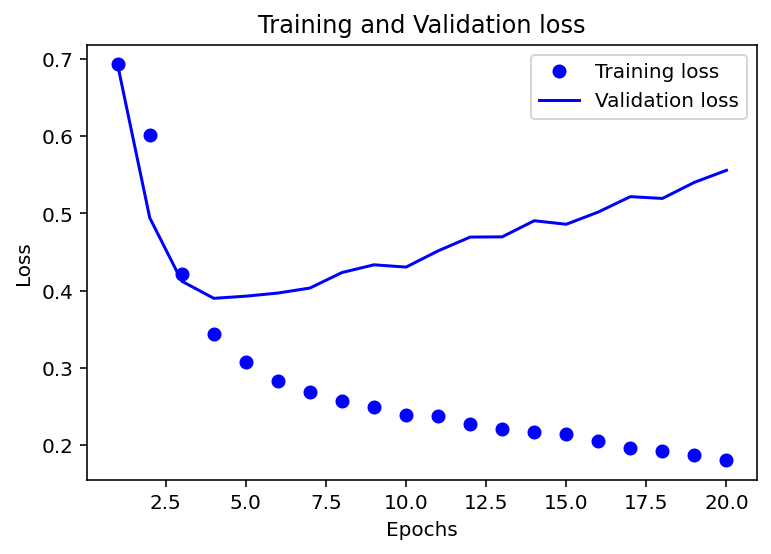

In [21]:
training_and_validation_loss(history_model1_dict)

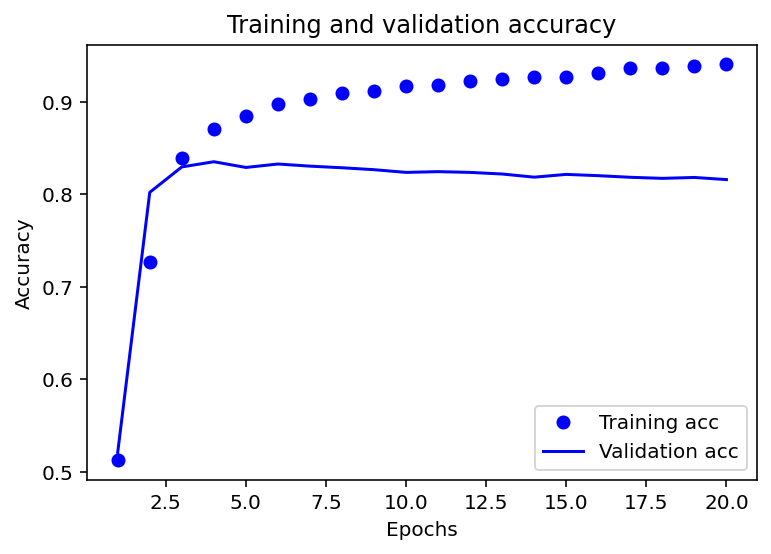

In [22]:
training_and_validation_accuracy(history_model1_dict)

In [25]:
results2 = model2.evaluate(X_test, y_test, verbose=2)

print(results2)

1537/1537 - 5s - loss: 0.9428 - accuracy: 0.7998
[0.9427742958068848, 0.7997640371322632]


In [26]:
history_model2_dict = history_model2.history

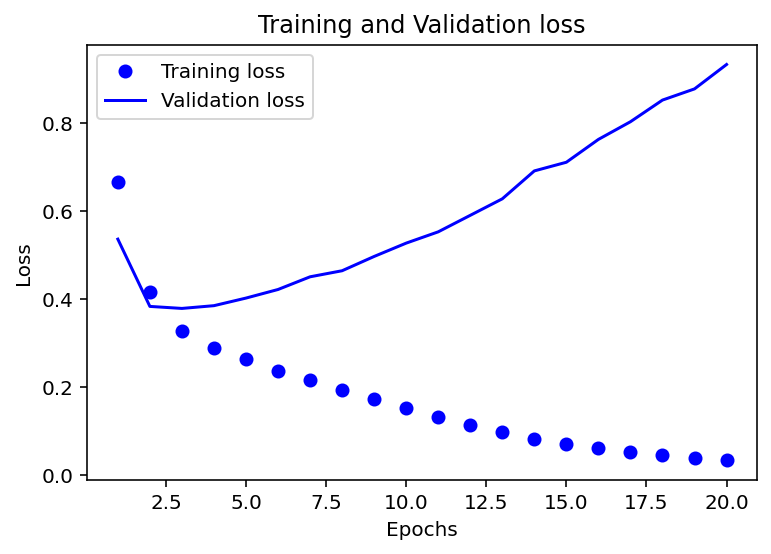

In [27]:
training_and_validation_loss(history_model2_dict)

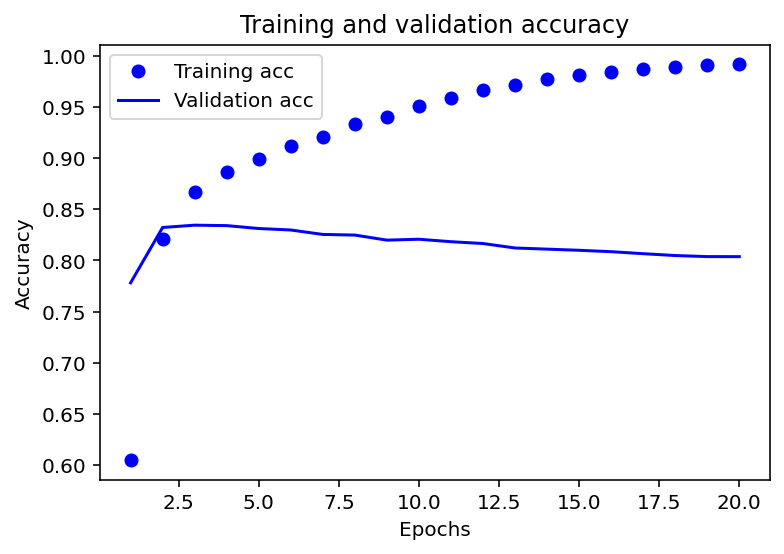

In [28]:
training_and_validation_accuracy(history_model2_dict)

In [31]:
results3 = model3.evaluate(X_test, y_test, verbose=2)

print(results3)

1537/1537 - 2s - loss: 0.5319 - accuracy: 0.8165
[0.5318891406059265, 0.8165266513824463]


In [32]:
history_model3_dict = history_model3.history

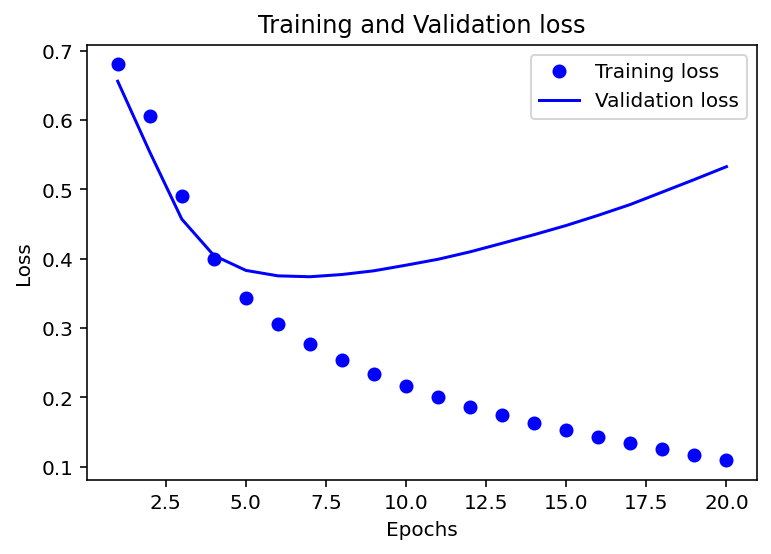

In [33]:
training_and_validation_loss(history_model3_dict)

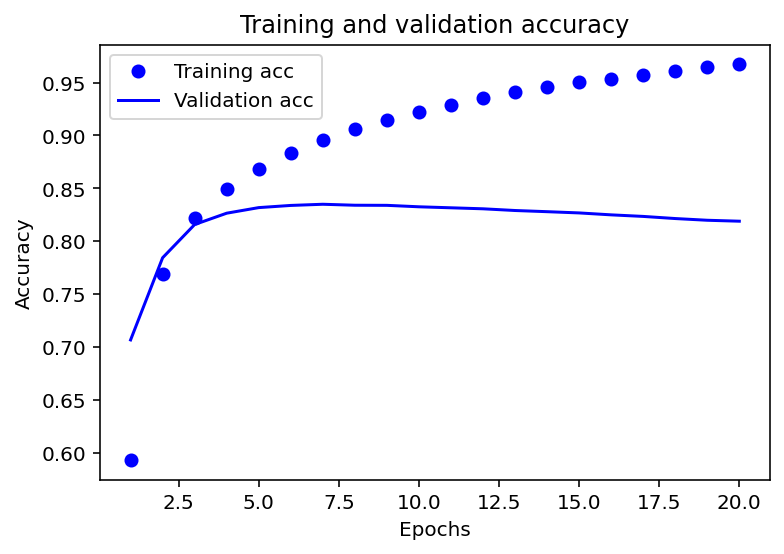

In [34]:
training_and_validation_accuracy(history_model3_dict)

## 8) 학습된 Embedding 레이어 분석

In [35]:
embedding_layer = model1.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)

(10001, 16)


In [37]:
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  

vectors = model1.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [38]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['컴퓨터']
vector

array([-0.0975752 ,  0.06080221, -0.07662478,  0.00733719, -0.08483528,
       -0.05893559, -0.0246463 ,  0.06208892,  0.02915857,  0.00967161,
        0.11484494, -0.02608119, -0.03138381,  0.09237063, -0.0853736 ,
       -0.21715379], dtype=float32)

In [39]:
word_vectors.similar_by_word('사랑')

[('세주', 0.9413070678710938),
 ('올려야', 0.9303186535835266),
 ('여운', 0.9288338422775269),
 ('축제', 0.9227619767189026),
 ('퀄리티', 0.9180200099945068),
 ('수작', 0.9152604341506958),
 ('김현주', 0.9136271476745605),
 ('아름답', 0.911962628364563),
 ('제주도', 0.9117700457572937),
 ('울린', 0.9113746881484985)]

In [40]:
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  

vectors = model2.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [41]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
word_vectors.similar_by_word('사랑')

[('영화배우', 0.9162090420722961),
 ('홍성진', 0.9080162644386292),
 ('퍼포먼스', 0.9031550288200378),
 ('햐', 0.9025687575340271),
 ('줄리안', 0.9019790291786194),
 ('색즉시공', 0.8943277597427368),
 ('치즈', 0.8927333354949951),
 ('트라우마', 0.8892480731010437),
 ('덴', 0.8841038346290588),
 ('최강희', 0.8833017349243164)]

In [42]:
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim)) 

vectors = model3.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [43]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
word_vectors.similar_by_word('사랑')

[('자연', 0.9437183141708374),
 ('카리스마', 0.9234826564788818),
 ('공원', 0.9077568650245667),
 ('고쳐', 0.8940828442573547),
 ('한가', 0.8801468014717102),
 ('조진웅', 0.8779309391975403),
 ('엄마', 0.8565728664398193),
 ('한텐', 0.8547372817993164),
 ('힙합', 0.8529605269432068),
 ('꺼져', 0.8444574475288391)]

## 9) 한국어 Word2Vec 임베딩을 활용하여 성능개선

* `https://fasttext.cc/docs/en/crawl-vectors.html` 에서 train data 수집

In [ ]:
remote_url = 'https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ko.300.vec.gz'
local_file = 'cc.ko.300.vec.gz'
request.urlretrieve(remote_url, local_file)

In [48]:
from gensim.models import KeyedVectors

word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/cc.ko.300.vec.gz'

word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=False, limit=1000000)
vector = word2vec['컴퓨터']
vector

array([-6.740e-02, -1.480e-02, -8.310e-02, -2.150e-02,  2.280e-02,
       -3.400e-03,  9.850e-02, -1.000e-04, -3.000e-04,  1.196e-01,
        1.540e-02, -5.700e-02,  6.840e-02, -1.800e-03, -2.140e-02,
       -5.740e-02,  6.920e-02, -4.750e-02,  3.120e-02,  3.250e-02,
       -1.038e-01, -1.520e-01,  1.093e-01, -1.007e-01,  5.180e-02,
        2.744e-01, -3.510e-02, -2.400e-03, -2.870e-02, -5.110e-02,
       -1.008e-01, -8.400e-03,  3.830e-02,  2.900e-02, -1.416e-01,
        9.250e-02, -5.440e-02,  2.090e-02, -1.880e-02,  4.190e-02,
       -1.540e-02,  7.730e-02, -3.750e-02,  1.010e-02, -4.330e-02,
       -4.130e-02,  8.150e-02, -9.400e-03,  1.192e-01,  2.460e-02,
       -3.910e-02,  6.360e-02, -4.800e-03, -5.200e-02, -1.762e-01,
        6.090e-02, -4.560e-02,  5.980e-02, -5.390e-02, -7.130e-02,
       -1.200e-03,  2.300e-02, -1.210e-02, -1.700e-02,  5.020e-02,
        1.027e-01, -8.750e-02, -3.320e-02,  1.610e-02,  1.870e-02,
       -5.100e-03, -1.411e-01,  8.200e-03,  1.440e-01, -2.830e

In [114]:
vocab_size = len(word_to_index)    # 어휘 사전의 크기
word_vector_dim = 300  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

In [115]:
from tensorflow.keras.initializers import Constant

vocab_size = len(word_to_index)    # 어휘 사전의 크기
word_vector_dim = 300  # 워드 벡터의 차원 수 

# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 41, 300)           3000300   
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 35, 16)            33616     
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 7, 16)             0         
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d_13 (Glo (None, 16)                0         
_________________________________________________________________
dense_28 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_29 (Dense)             (None, 1)               

In [116]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 15

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/15
86/86 [==============================] - 6s 61ms/step - loss: 0.6880 - accuracy: 0.5326 - val_loss: 0.5175 - val_accuracy: 0.7598
Epoch 2/15
86/86 [==============================] - 5s 60ms/step - loss: 0.4531 - accuracy: 0.7950 - val_loss: 0.4227 - val_accuracy: 0.8021
Epoch 3/15
86/86 [==============================] - 5s 59ms/step - loss: 0.3425 - accuracy: 0.8567 - val_loss: 0.3779 - val_accuracy: 0.8324
Epoch 4/15
86/86 [==============================] - 5s 58ms/step - loss: 0.2867 - accuracy: 0.8854 - val_loss: 0.3806 - val_accuracy: 0.8351
Epoch 5/15
86/86 [==============================] - 5s 59ms/step - loss: 0.2436 - accuracy: 0.9052 - val_loss: 0.3944 - val_accuracy: 0.8341
Epoch 6/15
86/86 [==============================] - 5s 59ms/step - loss: 0.2037 - accuracy: 0.9269 - val_loss: 0.4216 - val_accuracy: 0.8300
Epoch 7/15
86/86 [==============================] - 5s 58ms/step - loss: 0.1676 - accuracy: 0.9424 - val_loss: 0.4727 - val_accuracy: 0.8254
Epoch 8/15
86

In [117]:
results = model.evaluate(X_test, y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 0.9741 - accuracy: 0.8051
[0.9741401672363281, 0.805114209651947]


In [118]:
history_model_dict = history.history

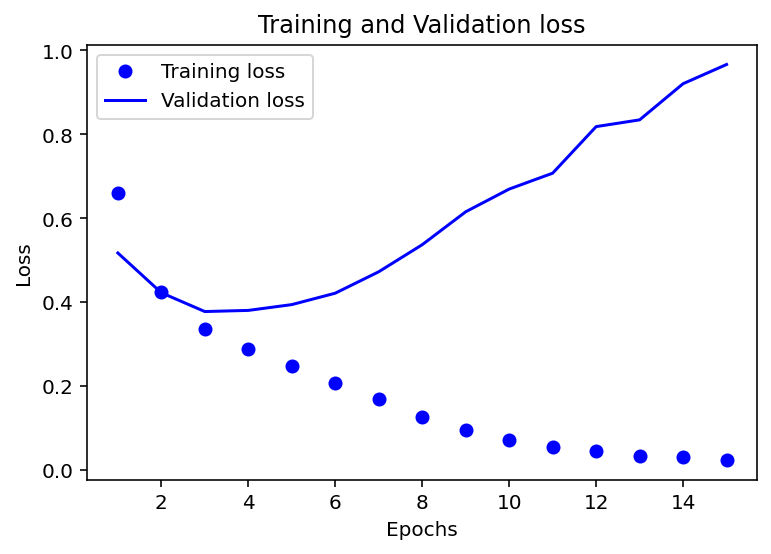

In [119]:
training_and_validation_loss(history_model_dict)

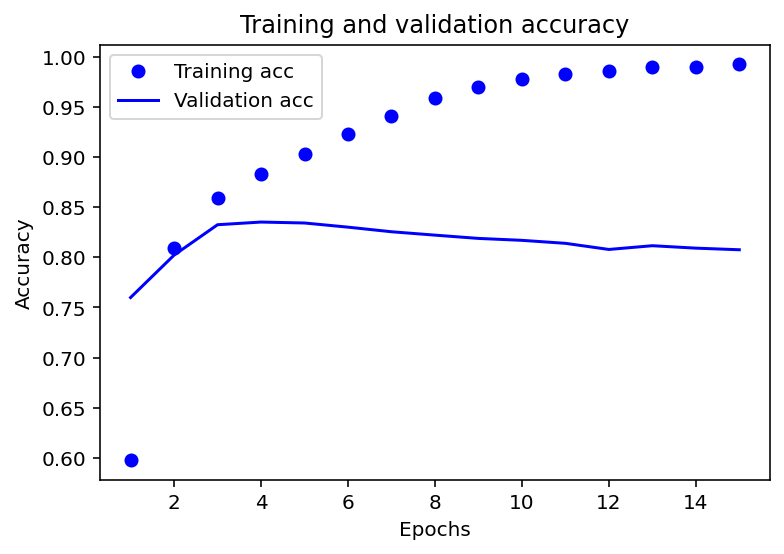

In [120]:
training_and_validation_accuracy(history_model_dict)

In [121]:
word2vec.similar_by_word("사랑")

[('세상끝의', 0.6162155866622925),
 ('몰래한', 0.5829073786735535),
 ('사랑을', 0.5812749266624451),
 ('한에스더', 0.5708735585212708),
 ('恋', 0.5509973764419556),
 ('연민', 0.5352497100830078),
 ('미움', 0.5222710371017456),
 ('友情', 0.5204496383666992),
 ('이별', 0.5188997387886047),
 ('사랑과', 0.5152379870414734)]